First 2 code cells only for Google Collab

In [1]:
!pip install -q git+https://github.com/tensorflow/docs 

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import Statements

In [23]:
import tensorflow
import pandas as pd
import time
import numpy as np

# tensorflow libraries
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Dense, Dropout, Normalization, StringLookup, IntegerLookup
from tensorflow.keras.optimizers import Adam
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots


# sklearn libraries are useful for preprocessing, performance measures, etc.
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import numpy as np
import pylab as plt
import multiprocessing as mp

# Part A: Classifications

# Read Data

In [3]:
df = pd.read_csv('./dataset/features_30_sec.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [4]:
df['label'].value_counts()

blues        100
classical    100
country      100
disco        100
hiphop       100
jazz         100
metal        100
pop          100
reggae       100
rock         100
Name: label, dtype: int64

In [5]:
columns_to_drop = ['label','filename', 'length']

def prepare_dataset(df, columns_to_drop, test_size, random_state):

    # Encode the labels from 0 to n_classes-1  
    label_encoder = preprocessing.LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['label'])
  
    # devide data to train and test
    df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)
    
    # scale the training inputs
    x_train = df_train.drop(columns_to_drop,axis=1)
    y_train = df_train['label'].to_numpy()
    
    standard_scaler = preprocessing.StandardScaler()
    x_train_scaled = standard_scaler.fit_transform(x_train)

    # scale and prepare testing data
    x_test = df_test.drop(columns_to_drop,axis=1)
    x_test_scaled = standard_scaler.transform(x_test)
    y_test = df_test['label'].to_numpy() 
  
    return x_train_scaled, y_train, x_test_scaled, y_test


Import training modules. Split and scale dataset.

In [6]:
X_train, Y_train, X_test, Y_test = prepare_dataset(df, columns_to_drop, test_size=0.3, random_state=0)
Y_train = tf.keras.utils.to_categorical(Y_train)
Y_test = tf.keras.utils.to_categorical(Y_test)


# Model

In [8]:
class Timekeeper (keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

def train_model(model, lr = 0.001, batch_size = 1, epochs = 50, verbose = 2, x_train = X_train, y_train = Y_train, x_test = X_test, y_test = Y_test):
    time_callback = Timekeeper()

    model.compile(optimizer = Adam(learning_rate = lr),
                                loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                                metrics = [tf.keras.losses.CategoricalCrossentropy(from_logits=True, name = 'ce'),
                                'accuracy'])
                                
    history = model.fit(x_train, y_train,
                        batch_size = batch_size,
                        epochs = 50, 
                        verbose = 2,
                        callbacks=[
                            tfdocs.modeling.EpochDots(),
                            time_callback
                        ],
                        validation_data=(x_test, y_test)
                        )
    
    return history, time_callback.times

def test_model(model, X_test = X_test, Y_test = Y_test, batch_size = 1):
  results = model.evaluate(X_test, Y_test, batch_size)
  return results

# Q1

Design a feedforward deep neural network (DNN) which consists of an input layer, one
hidden layer of 16 neurons with ReLU activation function, and an output softmax layer.
Use an stochastic gradient descent with ‘adam’ optimizer with default parameters, and
batch size = 1. Apply dropout of probability 0.3 to the hidden layer.
Divide the dataset into a 70:30 ratio for training and testing. Use appropriate scaling of
input features. We solely assume that there are only two datasets here: training & test.
We would look into validation in Question 2 onwards.

## Q1.a

Use the training dataset to train the model for 50 epochs. Note: Use 50
epochs for subsequent experiments.

In [10]:
histories = {}
model = Sequential([
                Dense(16, activation='relu'),
                Dropout(rate = 0.3),
                Dense(10, activation='softmax')
            ])

histories['q1_history'], _ = train_model(model)

Epoch 1/50
700/700 - 1s - loss: 2.2220 - ce: 2.2220 - accuracy: 0.2171 - val_loss: 1.8080 - val_ce: 1.8080 - val_accuracy: 0.3633

Epoch: 0, accuracy:0.2171,  ce:2.2220,  loss:2.2220,  val_accuracy:0.3633,  val_ce:1.8080,  val_loss:1.8080,  
.Epoch 2/50
700/700 - 1s - loss: 1.6969 - ce: 1.6969 - accuracy: 0.4029 - val_loss: 1.5336 - val_ce: 1.5336 - val_accuracy: 0.4533
.Epoch 3/50
700/700 - 1s - loss: 1.5096 - ce: 1.5096 - accuracy: 0.4686 - val_loss: 1.3791 - val_ce: 1.3791 - val_accuracy: 0.4900
.Epoch 4/50
700/700 - 1s - loss: 1.3245 - ce: 1.3245 - accuracy: 0.5371 - val_loss: 1.2876 - val_ce: 1.2876 - val_accuracy: 0.5067
.Epoch 5/50
700/700 - 1s - loss: 1.2267 - ce: 1.2267 - accuracy: 0.5443 - val_loss: 1.1898 - val_ce: 1.1898 - val_accuracy: 0.5367
.Epoch 6/50
700/700 - 1s - loss: 1.2162 - ce: 1.2162 - accuracy: 0.5329 - val_loss: 1.1784 - val_ce: 1.1784 - val_accuracy: 0.5667
.Epoch 7/50
700/700 - 1s - loss: 1.0795 - ce: 1.0795 - accuracy: 0.6229 - val_loss: 1.1041 - val_ce: 1.

## Q1.b

Plot accuracies on training and test data against training epochs and
comment on the plots.

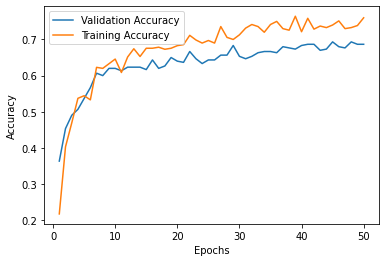

In [12]:
epochs = range(1, len(histories['q1_history'].history['accuracy'])+1)

plt.plot(epochs, histories['q1_history'].history['val_accuracy'], label='Validation Accuracy')
plt.plot(epochs, histories['q1_history'].history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Accuracy stabilises as loss values reaches convergence

## Q1.C

Plot the losses on training and test data against training epochs. State the
approximate number of epochs where the test error begins to converge.

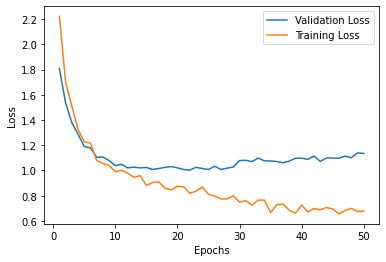

In [13]:
epochs = range(1, len(histories['q1_history'].history['loss'])+1)

plt.plot(epochs, histories['q1_history'].history['val_loss'], label='Validation Loss')
plt.plot(epochs, histories['q1_history'].history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Convergence begins at approximately 15 epochs when the validation loss stop decreasing.

# Q2

In this question, we will compare the performance of the model using stochastic gradient
descent and mini-batch gradient descent, as well as determining the optimal batch size
for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient
descent by training the neural network and evaluating the performances for different
batch sizes. Note: Use 3-fold cross-validation on training partition to perform parameter
selection.

In [14]:
import time

## Q2.a

Plot mean cross-validation accuracies over the training epochs for different
batch sizes. Limit search space to batch sizes {1,4,8,16,32, 64}.

In [15]:
batch_sizes = [1,4,8,16,32,64]
kfold = KFold(n_splits = 3, shuffle = True)

kfold_input = np.concatenate((X_train, X_test), axis = 0)
kfold_target = np.concatenate((Y_train, Y_test), axis = 0)

time_tracker = {}
history_list = []

fold = 1
for train, test in kfold.split(kfold_input,  kfold_target):
    for batch in batch_sizes:
        histories = {}
        model = Sequential([
                Dense(16, activation='relu'),
                Dropout(rate = 0.3),
                Dense(10, activation='softmax')
            ])
        histories[f'q2_batch{batch}_fold{fold}'], time_tracker[f'q2_batch{batch}_fold{fold}'] = train_model(model, batch_size = batch, x_train = kfold_input[train], y_train = kfold_target[train])
        history_list.append(histories)

    fold += 1

Epoch 1/50
666/666 - 1s - loss: 2.1445 - ce: 2.1445 - accuracy: 0.2342 - val_loss: 1.7244 - val_ce: 1.7244 - val_accuracy: 0.3700

Epoch: 0, accuracy:0.2342,  ce:2.1445,  loss:2.1445,  val_accuracy:0.3700,  val_ce:1.7244,  val_loss:1.7244,  
.Epoch 2/50
666/666 - 1s - loss: 1.6628 - ce: 1.6628 - accuracy: 0.3784 - val_loss: 1.4452 - val_ce: 1.4452 - val_accuracy: 0.4867
.Epoch 3/50
666/666 - 1s - loss: 1.4976 - ce: 1.4976 - accuracy: 0.4625 - val_loss: 1.2833 - val_ce: 1.2833 - val_accuracy: 0.5167
.Epoch 4/50
666/666 - 1s - loss: 1.3788 - ce: 1.3788 - accuracy: 0.4940 - val_loss: 1.1821 - val_ce: 1.1821 - val_accuracy: 0.5633
.Epoch 5/50
666/666 - 1s - loss: 1.2869 - ce: 1.2869 - accuracy: 0.5601 - val_loss: 1.1031 - val_ce: 1.1031 - val_accuracy: 0.6200
.Epoch 6/50
666/666 - 1s - loss: 1.2703 - ce: 1.2703 - accuracy: 0.5315 - val_loss: 1.0343 - val_ce: 1.0343 - val_accuracy: 0.6267
.Epoch 7/50
666/666 - 1s - loss: 1.2120 - ce: 1.2120 - accuracy: 0.5511 - val_loss: 0.9935 - val_ce: 0.

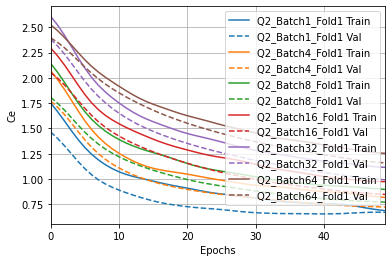

In [16]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'ce', smoothing_std=10)

# fold 1 by batches
plotter.plot(history_list[0])
plotter.plot(history_list[1])
plotter.plot(history_list[2])
plotter.plot(history_list[3])
plotter.plot(history_list[4])
plotter.plot(history_list[5])


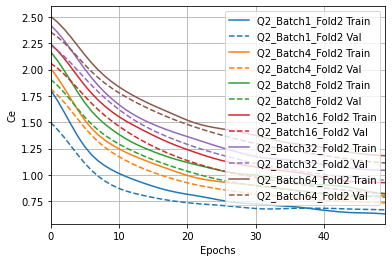

In [17]:
# fold 2 by batches
plotter.plot(history_list[6])
plotter.plot(history_list[7])
plotter.plot(history_list[8])
plotter.plot(history_list[9])
plotter.plot(history_list[10])
plotter.plot(history_list[11])


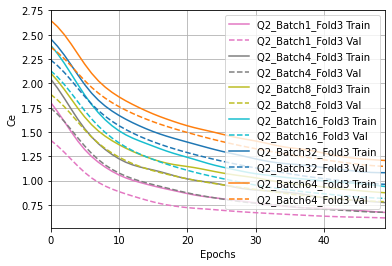

In [18]:
# fold 3 by batches
plotter.plot(history_list[12])
plotter.plot(history_list[13])
plotter.plot(history_list[14])
plotter.plot(history_list[15])
plotter.plot(history_list[16])
plotter.plot(history_list[17])


From the results across the 3 folds we can see that batches 1, 4 and 8 results in lower cross-entropy losses. We can take a closer look individually among them.

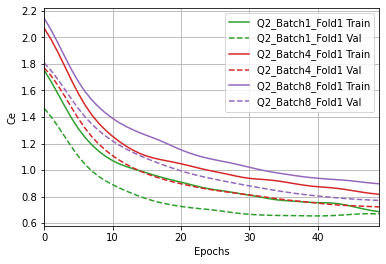

In [19]:
# fold 1
plotter.plot(history_list[0])
plotter.plot(history_list[1])
plotter.plot(history_list[2])

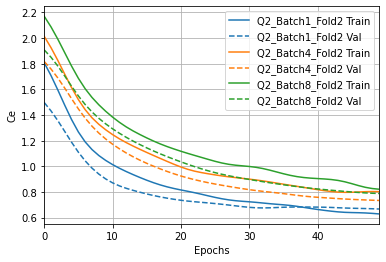

In [20]:
# fold 2
plotter.plot(history_list[6])
plotter.plot(history_list[7])
plotter.plot(history_list[8])

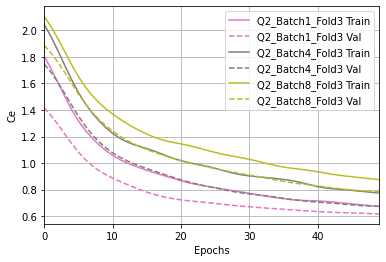

In [21]:
# fold 3
plotter.plot(history_list[12])
plotter.plot(history_list[13])
plotter.plot(history_list[14])

Batch 1 seems to produce a lower cross-entropy loss in general over time.

## Q2b. Create a table of median time

In [22]:
for time in time_tracker:
  print(f'{time}: {np.average(time_tracker[time])}')

q2_batch1_fold1: 1.0487424564361572
q2_batch4_fold1: 0.3265849542617798
q2_batch8_fold1: 0.19148481845855714
q2_batch16_fold1: 0.11118525505065918
q2_batch32_fold1: 0.06435465812683105
q2_batch64_fold1: 0.04395009517669678
q2_batch1_fold2: 0.976978669166565
q2_batch4_fold2: 0.3720931339263916
q2_batch8_fold2: 0.21482831001281738
q2_batch16_fold2: 0.11942761421203613
q2_batch32_fold2: 0.06896428108215331
q2_batch64_fold2: 0.048268518447875976
q2_batch1_fold3: 1.0507742929458619
q2_batch4_fold3: 0.373451452255249
q2_batch8_fold3: 0.21598271846771241
q2_batch16_fold3: 0.12000624656677246
q2_batch32_fold3: 0.07170919895172119
q2_batch64_fold3: 0.047900118827819825


## Q2.c Select optimal batch size

It can be determined that the optimal batch size is batch 8. To determine the optimal batch size we need to consider the training time and cross-entropy tradeoff. Out of the 3 batch sizes with good best cross-entropy loss, batch 8 has the fastest training time. This means that it can produce a good result within a decent training timespan. Thus we can determine that batch size 8 is optimal.

## Q2.d What is the difference between mini-batch gradient descent and stochastic gradient descent and what does this mean for model training?

In mini-batch gradient descent, training is performed on a subset batch of training patterns where as in stochastic gradient descent, every single pattern of training data is trained. The implications on the model will be its accuracy and training time. By performing training on a group of training patterns the training process is faster as it will take lesser iterations to cover all training patterns. Mini-batch is good when the dataset is huge. On the other hand, training on every single patterns individually naturally leads to longer time taken. However, accuracy would be higher as every single training pattern is taken into account. Furthermore, SGD worlds well when there are lots of local maxima/minima dure to its nature. Thus, both method is effective in their respective circumstances.

## Q2.d  Plot the train and test accuracies against epochs for the optimal batch size. 



IndexError: list index out of range

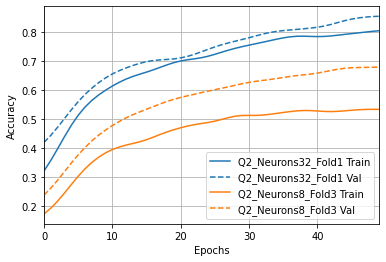

In [31]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter.plot(history_list[2])
plotter.plot(history_list[8])
plotter.plot(history_list[14])

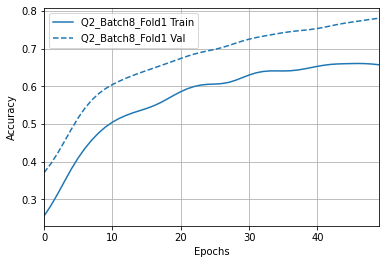

In [24]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter.plot(history_list[2])

Across the 3 folds, validation accuracy is higher than training accuracy signifying that model has generalized fine. Fold 1 produced the highest accuracy as such, the model can be said to be the more optimal.

# Q3 

Find the optimal number of hidden neurons for the 2-layer network (i.e., one hidden layer) designed in Question 1 and 2.

In [40]:
import time

## Q3.a Plot the cross-validation accuracies against training epochs for different numbers of hidden-layer neurons. Limit the search space of the number of neurons to {8, 16, 32, 64}. Continue using 3-fold cross validation on training dataset.

In [27]:
no_of_neuron = [8, 16, 32, 64]
batch_size = 8 # selected optimal batch size
kfold = KFold(n_splits = 3, shuffle = True)

kfold_input = np.concatenate((X_train, X_test), axis = 0)
kfold_target = np.concatenate((Y_train, Y_test), axis = 0)

time_tracker = {}
history_list = []

fold = 1
for train, test in kfold.split(kfold_input,  kfold_target):
    for neuron in no_of_neuron:
        histories = {}
        model = Sequential([
                Dense(neuron, activation='relu'),
                Dropout(rate = 0.3),
                Dense(10, activation='softmax')
            ])
        histories[f'q2_neurons{neuron}_fold{fold}'], time_tracker[f'q2_neurons{neuron}_fold{fold}'] = train_model(model, batch_size = batch_size, x_train = kfold_input[train], y_train = kfold_target[train])
        history_list.append(histories)

    fold += 1

Epoch 1/50


D:\anaconda3\envs\MDP\lib\site-packages\tensorflow\python\keras\backend.py:4869: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


84/84 - 1s - loss: 2.4774 - ce: 2.4871 - accuracy: 0.1276 - val_loss: 2.3154 - val_ce: 2.3172 - val_accuracy: 0.1400

Epoch: 0, accuracy:0.1276,  ce:2.4871,  loss:2.4774,  val_accuracy:0.1400,  val_ce:2.3172,  val_loss:2.3154,  
.Epoch 2/50
84/84 - 0s - loss: 2.2322 - ce: 2.2317 - accuracy: 0.1877 - val_loss: 2.1559 - val_ce: 2.1582 - val_accuracy: 0.2267
.Epoch 3/50
84/84 - 0s - loss: 2.1037 - ce: 2.1057 - accuracy: 0.2928 - val_loss: 2.0523 - val_ce: 2.0554 - val_accuracy: 0.2967
.Epoch 4/50
84/84 - 0s - loss: 2.0325 - ce: 2.0348 - accuracy: 0.3063 - val_loss: 1.9732 - val_ce: 1.9768 - val_accuracy: 0.3400
.Epoch 5/50
84/84 - 0s - loss: 1.8750 - ce: 1.8727 - accuracy: 0.3904 - val_loss: 1.9018 - val_ce: 1.9061 - val_accuracy: 0.3633
.Epoch 6/50
84/84 - 0s - loss: 1.8511 - ce: 1.8478 - accuracy: 0.3904 - val_loss: 1.8442 - val_ce: 1.8487 - val_accuracy: 0.3767
.Epoch 7/50
84/84 - 0s - loss: 1.7980 - ce: 1.7922 - accuracy: 0.3859 - val_loss: 1.7944 - val_ce: 1.7995 - val_accuracy: 0.39

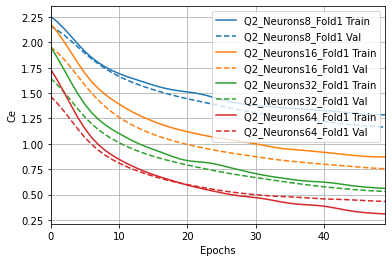

In [28]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'ce', smoothing_std=10)
# fold 1
plotter.plot(history_list[0])
plotter.plot(history_list[1])
plotter.plot(history_list[2])
plotter.plot(history_list[3])

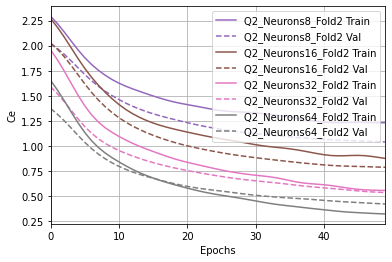

In [29]:
# fold 2
plotter.plot(history_list[4])
plotter.plot(history_list[5])
plotter.plot(history_list[6])
plotter.plot(history_list[7])

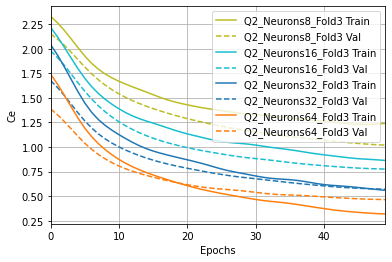

In [30]:
# fold 3
plotter.plot(history_list[8])
plotter.plot(history_list[9])
plotter.plot(history_list[10])
plotter.plot(history_list[11])

## Q3.b Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

16 Neurons. The plot of 16 neurons shows better generalisation as validation and training curve are neither too close nor too far apart.

## Q3.c Plot the train and test accuracies against training epochs with the optimal number of neurons.

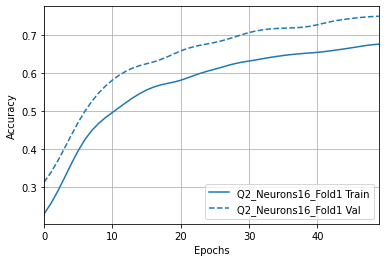

In [32]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter.plot(history_list[1])

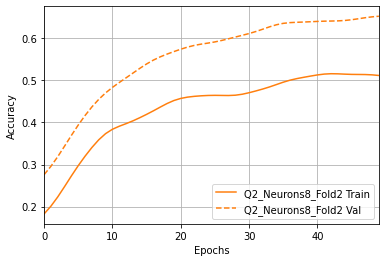

In [33]:
plotter.plot(history_list[5])

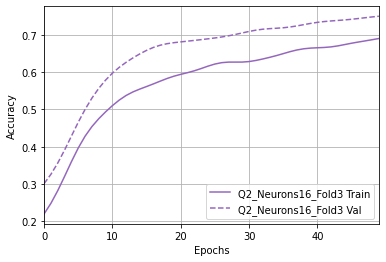

In [35]:
plotter.plot(history_list[9])

## Q3.d What other parameters could possibly be tuned? 

Learning rate, dropout rate, number of epochs.

# Q4

After you are done with the 2-layer network, design a 3-layer network with two hiddenlayers with ReLU activation, each consisting of the optimal number of neurons you obtained in Question 3, (apply a dropout with a probability of 0.3 for each hidden layer), and train it with a batch size of 1.

In [66]:
import time
X_train, Y_train, X_test, Y_test = prepare_dataset(df, columns_to_drop, test_size=0.3, random_state=0)
Y_train = tf.keras.utils.to_categorical(Y_train)
Y_test = tf.keras.utils.to_categorical(Y_test)


## Q4.a  Plot the train and test accuracy of the 3-layer network against training epochs.

In [67]:
batch_size = 1 # selected optimal batch size
neuron = 16 # selected optimal no. of neurons

history_list = []

models = [
        Sequential([
            Dense(neuron, activation='relu'),
            Dropout(rate = 0.3),
            Dense(10, activation='softmax')
        ]),
        Sequential([
            Dense(neuron, activation='relu'),
            Dropout(rate = 0.3),
            Dense(neuron, activation='relu'),
            Dropout(rate = 0.3),
            Dense(10, activation='softmax')
        ])
      ]


j = 2
for model in models:
        histories = {}
        histories[f'q2_layers{j}'], time_tracker[f'q2_layers{j}'] = train_model(model, batch_size = batch_size)
        history_list.append(histories)
        j += 1

Epoch 1/50


D:\anaconda3\envs\MDP\lib\site-packages\tensorflow\python\keras\backend.py:4869: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


700/700 - 2s - loss: 2.2620 - ce: 2.2620 - accuracy: 0.2043 - val_loss: 1.7494 - val_ce: 1.7494 - val_accuracy: 0.3800

Epoch: 0, accuracy:0.2043,  ce:2.2620,  loss:2.2620,  val_accuracy:0.3800,  val_ce:1.7494,  val_loss:1.7494,  
.Epoch 2/50
700/700 - 1s - loss: 1.7518 - ce: 1.7518 - accuracy: 0.3214 - val_loss: 1.4945 - val_ce: 1.4945 - val_accuracy: 0.4433
.Epoch 3/50
700/700 - 1s - loss: 1.5727 - ce: 1.5727 - accuracy: 0.4414 - val_loss: 1.3538 - val_ce: 1.3538 - val_accuracy: 0.5000
.Epoch 4/50
700/700 - 1s - loss: 1.3903 - ce: 1.3903 - accuracy: 0.4814 - val_loss: 1.2765 - val_ce: 1.2765 - val_accuracy: 0.5233
.Epoch 5/50
700/700 - 1s - loss: 1.2641 - ce: 1.2641 - accuracy: 0.5486 - val_loss: 1.2230 - val_ce: 1.2230 - val_accuracy: 0.5400
.Epoch 6/50
700/700 - 1s - loss: 1.2358 - ce: 1.2358 - accuracy: 0.5414 - val_loss: 1.1948 - val_ce: 1.1948 - val_accuracy: 0.5633
.Epoch 7/50
700/700 - 1s - loss: 1.2266 - ce: 1.2266 - accuracy: 0.5343 - val_loss: 1.1578 - val_ce: 1.1578 - val_

## Q4.b Compare and comment on the performances of the optimal 2-layer network from your hyperparameter tuning in Question 2 and 3 and the 3-layer network

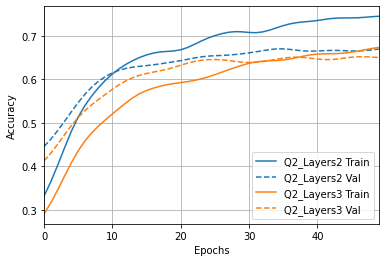

In [68]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter.plot(history_list[0])
plotter.plot(history_list[1])

It can be seen that a 2 layer network generally outperforms a 2 layer network in terms of its accuracy. The reason for this could potentially be that in a 3 layer network, there are more parameters to learn and a longer training time/more tuning could be required. It can be noted that the higher accuracy in the 2 layer network could mean that it does not generalize as well as the 3 layer network.

# Q5

We are going to dissect the purpose of dropout in the model

## Q5.a Why do we add dropouts? Investigate the purpose of dropouts by removing dropouts from your original 2-layer network (before changing the batch size and number of neurons). Plot accuracies on training and test data with neural network without dropout. Plot as well the losses on training and test data with neural network without dropout.

Dropout prevent neuron units from interdependnce by ignoring subset of units using a set probability.

In [70]:
import time
X_train, Y_train, X_test, Y_test = prepare_dataset(df, columns_to_drop, test_size=0.3, random_state=0)
Y_train = tf.keras.utils.to_categorical(Y_train)
Y_test = tf.keras.utils.to_categorical(Y_test)


In [71]:
# training with dropout
histories = {}
model = Sequential([
                Dense(16, activation='relu'),
                Dropout(rate = 0.3),
                Dense(10, activation='softmax')
            ])

histories['dropout'], _ = train_model(model)

# training without dropout
model = Sequential([
                Dense(16, activation='relu'),
                Dense(10, activation='softmax')
            ])

histories['no_dropout'], _ = train_model(model)


Epoch 1/50


D:\anaconda3\envs\MDP\lib\site-packages\tensorflow\python\keras\backend.py:4869: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


700/700 - 1s - loss: 2.2176 - ce: 2.2176 - accuracy: 0.2514 - val_loss: 1.8655 - val_ce: 1.8655 - val_accuracy: 0.3200

Epoch: 0, accuracy:0.2514,  ce:2.2176,  loss:2.2176,  val_accuracy:0.3200,  val_ce:1.8655,  val_loss:1.8655,  
.Epoch 2/50
700/700 - 1s - loss: 1.6958 - ce: 1.6958 - accuracy: 0.3914 - val_loss: 1.5964 - val_ce: 1.5964 - val_accuracy: 0.4133
.Epoch 3/50
700/700 - 1s - loss: 1.5504 - ce: 1.5504 - accuracy: 0.4371 - val_loss: 1.4757 - val_ce: 1.4757 - val_accuracy: 0.4500
.Epoch 4/50
700/700 - 1s - loss: 1.4060 - ce: 1.4060 - accuracy: 0.4643 - val_loss: 1.3594 - val_ce: 1.3594 - val_accuracy: 0.5167
.Epoch 5/50
700/700 - 1s - loss: 1.3259 - ce: 1.3259 - accuracy: 0.5086 - val_loss: 1.2790 - val_ce: 1.2790 - val_accuracy: 0.5333
.Epoch 6/50
700/700 - 1s - loss: 1.2301 - ce: 1.2301 - accuracy: 0.5386 - val_loss: 1.2214 - val_ce: 1.2214 - val_accuracy: 0.5500
.Epoch 7/50
700/700 - 1s - loss: 1.1640 - ce: 1.1640 - accuracy: 0.5571 - val_loss: 1.1815 - val_ce: 1.1815 - val_

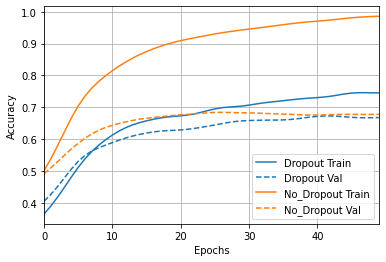

In [73]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter.plot(histories)

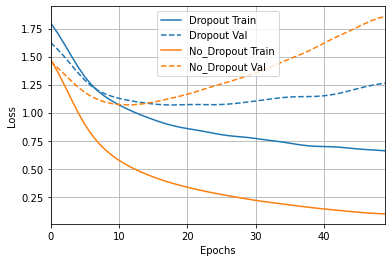

In [74]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
plotter.plot(histories)

## Q5.b

It is very obvious that without dropout, the model overfits. The accuracy is very close to 1 and the loss on test data increases after 10 epochs.

## Q5.c What is another approach that you could take to address overfitting in the model?

Possible techniques to address overfitting:


*   L1/L2 regularization: Punishes network from learning overly-complicated model
*   Learn the more significant features

*   Image augmentation (more for image classification than current task)





# Conclusion

To conclude from all the expriments, we determine that when coming up with a neural network to tackle a given tasks, we are not just training to find the best weight, but also fine-tuning to find the best hyperparameters. Out of the parameters tuned, dropout has the highest impact on model performance. The reason for this is that the model is extremely small and can overfit very easily. Dropout allows us to fine-tune to model to perform decently. In our course of fine-tuning the model, we can draw from the results that it is important to balance the training-time/accuracy trade-off. In a real world scenario, small percentage of accuracy may be sacrificed in order to achieve a faster response time (running object detection on edge devices etc.). To balance the tradeoff we have to adjust batch size, layer size and depth. Other parameters to tune include but not limited to: learning rate, number of epochs, optimizers used and percentage of train/test split. There are many parameters that we can tune (especially in large architectures such as a CNN) and there fore it is crucial to understand our task before start our experiments (For example, if we expect many local minma/maxima we can start training using SGD as opposed to mini-batch).

By modelling waveform data we can use this approach for tasks such as earthquake detection. Certainly the model will be more complex with more hyperparameters to tune.

Another approach for this task could be to use a CNN. A CNN would be able to learn more paramters and perform better than this simple model. Of course, a more data would probably be required as CNNs are more data hungry.

1 thing I would add to the tuning pipeline is to expriment with number of epochs.

# Part B: Regression

In [125]:
# Setting the seed here is sufficient. 
# If you don't plan to use these starter code, make sure you add this cell.
import os
import random 

SEED = 42

os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Import dataset

In [126]:
import pandas as pd
df = pd.read_csv('./dataset/hdb_price_prediction.csv')
df.head()

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0


In [127]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


# Q1

## Q1.a Divide the dataset (‘HDB_price_prediction.csv’) into train and test sets by using entries from year 2020 and before as training data (with the remaining data from year 2021 used as test data). Why is this done instead of random train/test splits?

In [137]:
#Split data
train_dataframe = df[df['year'] <= 2020] # 0.8393471285568813
val_dataframe = df[df['year'] > 2020]

train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

train_ds = train_ds.batch(128)
val_ds = val_ds.batch(128)

Data is split this way because we want to ensure that the model is able to perform well in future predictions. By training on data from 2020 and performing well on test data from after 2021, it means that the model is able to predict future results.

## Q1.b Following this tutorial, design a 2-layer feedforward neural network consisting of an input layer, a hidden layer (10 neurons, ReLU as activation function), and a linear output layer. One-hot encoding should be applied to categorical features and numeric features are standardised. After encoding / standardisation, the input features should be concatenated. 

In [7]:
# Categorical features encoded as integers
month = keras.Input(shape=(1,), name="month", dtype="int64")
month_encoded = encode_categorical_feature(month, "month", train_ds, False)

# Categorical feature encoded as string
flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
flat_model_type_encoded = encode_categorical_feature(flat_model_type, "flat_model_type", train_ds, True)

storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")
storey_range_encoded = encode_categorical_feature(storey_range, "storey_range", train_ds, True)

# Numerical features
floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)

dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)

dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)

degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)

eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)

remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)

all_inputs = [
        month,
        flat_model_type,
        storey_range,
        floor_area_sqm,
        dist_to_nearest_stn,
        dist_to_dhoby,
        degree_centrality,
        eigenvector_centrality,
        remaining_lease_years
]

all_features = layers.concatenate(
    [
        month_encoded,
        flat_model_type_encoded,
        storey_range_encoded,
        floor_area_sqm_encoded,
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded,
        degree_centrality_encoded,
        eigenvector_centrality_encoded,
        remaining_lease_years_encoded
    ]
)


In [33]:
# feedforward network with one hidden layer
x = layers.Dense(10, activation="relu")(all_features)
output = layers.Dense(1, activation="linear")(x)
model = keras.Model(all_inputs, output)

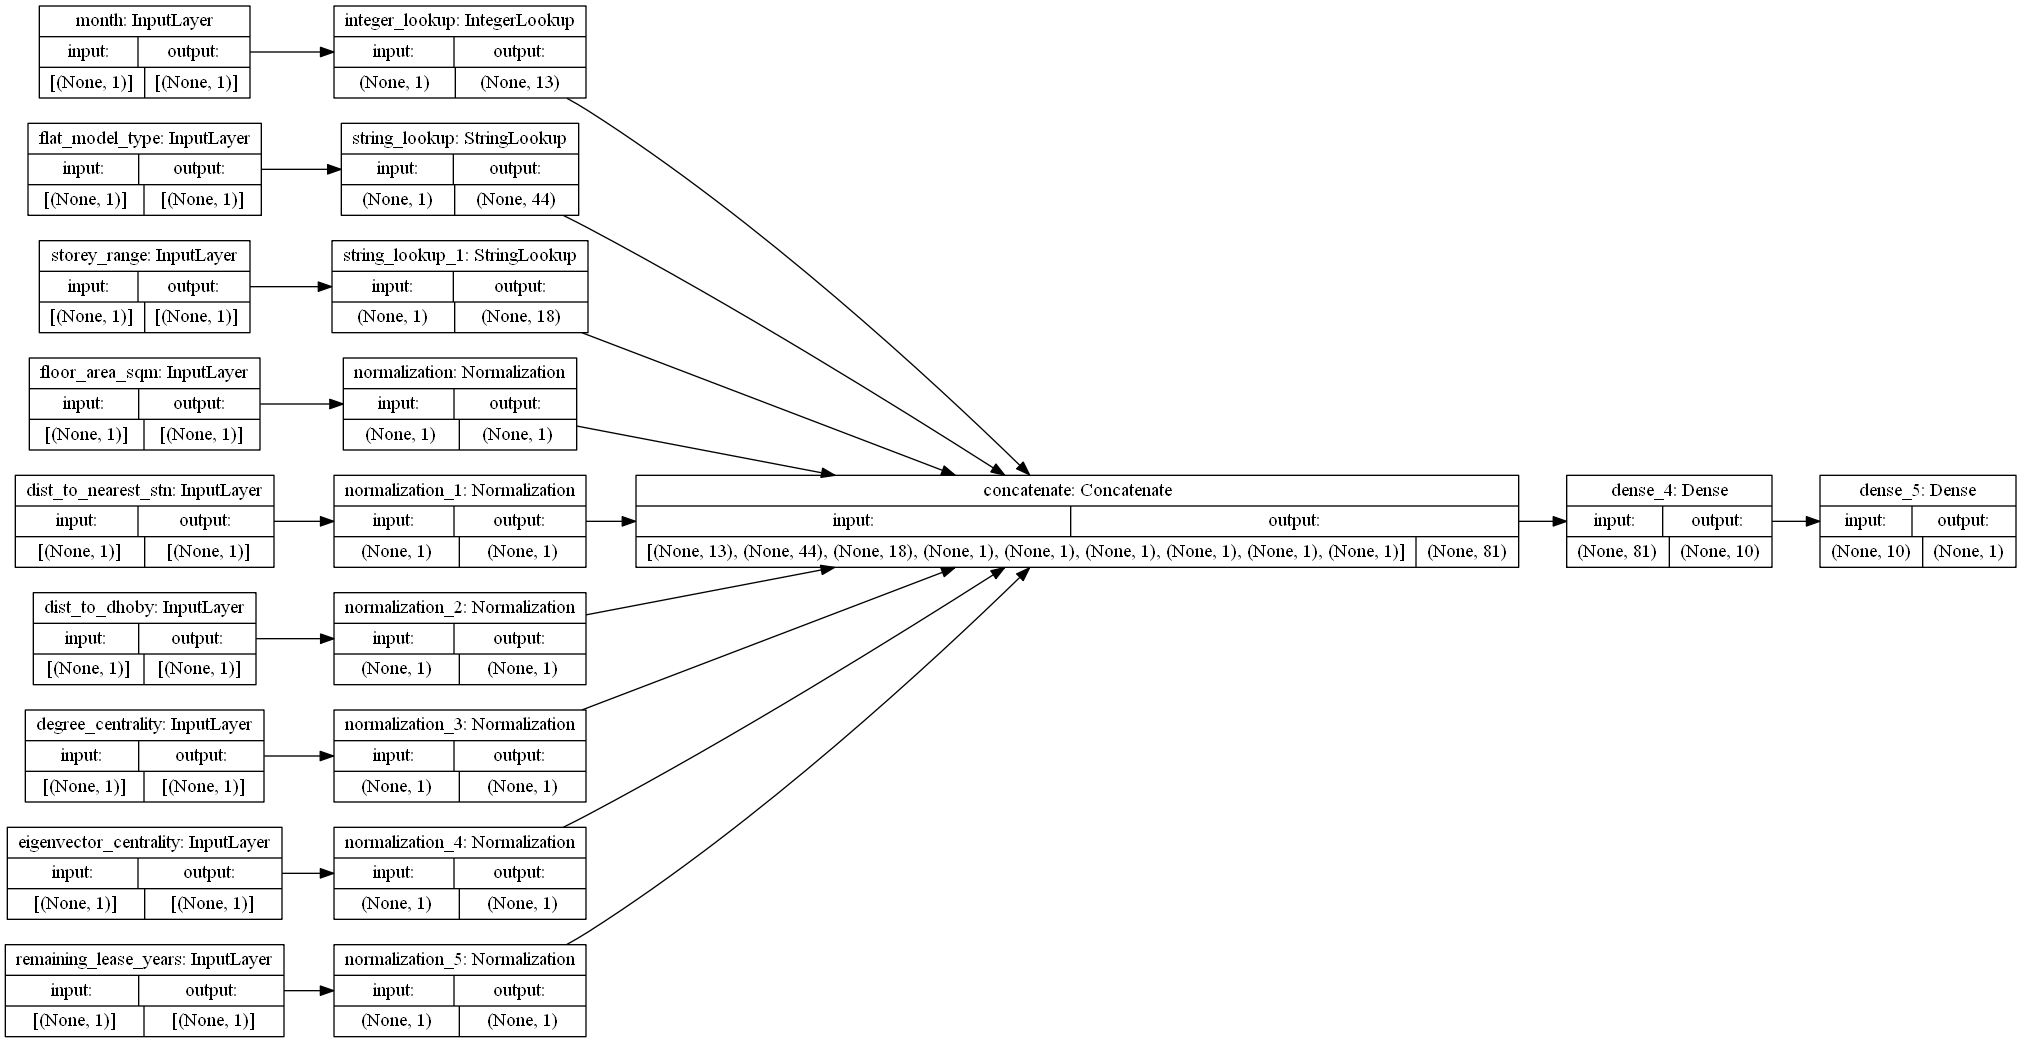

In [15]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

## Q1.c On the training data, train the model for 100 epochs using mini-batch gradient descent with batch size = 128, Use ‘adam’ optimiser with a learning rate of 𝛼 = 0.05 and mean square error as cost function. (Tip: Use smaller epochs while you’re still debugging. On Google Colaboratory, 100 epochs take around 10 minutes even without GPU.)


In [34]:
# for part d
def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [35]:
model.compile(optimizer = Adam(learning_rate = 0.05),
                                loss = 'mean_squared_error',
                                metrics = [tf.keras.metrics.RootMeanSquaredError(), 'mean_squared_error', r2_score])
modal_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./model/',
    save_best_only=True,
    monitor='val_mean_squared_error'
)                                
history = model.fit(train_ds, epochs = 100, batch_size=128, validation_data=val_ds, callbacks=[modal_checkpoint_callback])

Epoch 1/100


D:\anaconda3\envs\MDP\lib\site-packages\keras\engine\functional.py:582: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


683/683 [==============================] - 4s 5ms/step - loss: 202404298752.0000 - root_mean_squared_error: 449893.6250 - mean_squared_error: 202404298752.0000 - r2_score: -7.7325 - val_loss: 218944208896.0000 - val_root_mean_squared_error: 467914.7500 - val_mean_squared_error: 218944208896.0000 - val_r2_score: -7.6077
INFO:tensorflow:Assets written to: ./model\assets
Epoch 2/100
683/683 [==============================] - 4s 5ms/step - loss: 121559433216.0000 - root_mean_squared_error: 348653.7500 - mean_squared_error: 121559433216.0000 - r2_score: -4.2256 - val_loss: 107008401408.0000 - val_root_mean_squared_error: 327121.3750 - val_mean_squared_error: 107008401408.0000 - val_r2_score: -3.2002
INFO:tensorflow:Assets written to: ./model\assets
Epoch 3/100
683/683 [==============================] - 4s 5ms/step - loss: 42673815552.0000 - root_mean_squared_error: 206576.4219 - mean_squared_error: 42673815552.0000 - r2_score: -0.8294 - val_loss: 34592788480.0000 - val_root_mean_squared_err

## Q1.d Plot the train and test root mean square errors (RMSE) against epochs (Tip: skip the first few epochs, else the plot gets dominated by them). 

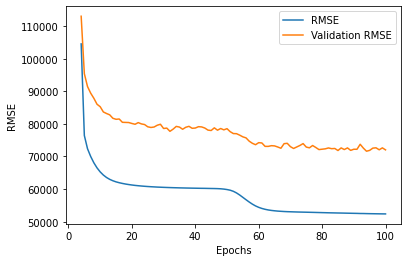

In [36]:
# skip first 4 epochs to not get overwhelmed by high value
epochs = range(4, len(history.history['root_mean_squared_error'])+1)

plt.plot(epochs, history.history['root_mean_squared_error'][3:], label='RMSE')
plt.plot(epochs, history.history['val_root_mean_squared_error'][3:], label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

plt.show()


## Q1.e State the epoch with the lowest test error. State the test R2 value at that epoch. (Hint: Check the output returned by model.fit(). Use a custom metric for computing R2.)


In [41]:
idx_lowest_err = np.argmin(history.history["val_root_mean_squared_error"])
print(f'Lowest test error epoch: {idx_lowest_err}')
print(f'Lowest test error score: {history.history["val_root_mean_squared_error"][idx_lowest_err]}')
print(f'R2 Score at lowest test error: {history.history["val_r2_score"][idx_lowest_err]}')

Lowest test error epoch: 93
Lowest test error score: 71607.46875
R2 Score at lowest test error: 0.7987581491470337


In [42]:
print(f'R2 Score at lowest test error: {history.history["val_r2_score"][93]}')

R2 Score at lowest test error: 0.7987581491470337


## Q1.f Using the model from that best epoch, plot the predicted values and target values for a batch of 128 test samples. (Hint: Use a callback to restore the best model weights. Find out how to retrieve a batch from tf.BatchDataset. A scatter plot will suffice.)

In [150]:
model.load_weights('./model/')
results = model.predict(val_ds)
print(val_ds)

# plt.scatter(results, results)





# val_dataframe = df[df['year'] > 2020]
# val_dataframe = val_dataframe.copy()
# labels = val_dataframe.pop("resale_price")
# ds = tf.data.Dataset.from_tensor_slices((dict(val_dataframe)))
# ds = ds.shuffle(buffer_size=len(val_dataframe))
# tval_ds = ds
# tval_ds = tval_ds.batch(128)

# d = np.stack(list(tval_ds))
# print(tval_ds.as_numpy_iterator())
# for i in range(len(tval_ds)):
#     i = 0
#     # print(data[0]['resale_price'])
#     for resale_price in data[0]['resale_price']:
#         print()
#         plt.scatter(resale_price, results[i])
#         i+=1

<BatchDataset shapes: ({month: (None,), year: (None,), full_address: (None,), nearest_stn: (None,), dist_to_nearest_stn: (None,), dist_to_dhoby: (None,), degree_centrality: (None,), eigenvector_centrality: (None,), flat_model_type: (None,), remaining_lease_years: (None,), floor_area_sqm: (None,), storey_range: (None,)}, (None,)), types: ({month: tf.int64, year: tf.int64, full_address: tf.string, nearest_stn: tf.string, dist_to_nearest_stn: tf.float64, dist_to_dhoby: tf.float64, degree_centrality: tf.float64, eigenvector_centrality: tf.float64, flat_model_type: tf.string, remaining_lease_years: tf.float64, floor_area_sqm: tf.float64, storey_range: tf.string}, tf.float64)>
